# Importação dos dados

In [ ]:
!pip install gdown
import gdown

# Google file ID
file_id = '1ZmJU9Wrzcu0D6oyb2QKtOthnIs-r3tGL'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'market_basket.zip'  #Faz uma cópia para armazenamento local

gdown.download(url, output, quiet=True)

'market_basket.zip'

In [ ]:
import zipfile


zip_file_path = 'market_basket.zip'

# Coloca as planilhas em um diretório
extract_dir = 'dataset_zipado'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# Instalar Spark e dependências
!apt-get install openjdk-11-jdk
!wget https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install findspark

import os
import findspark

# Setar env
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.4.1-bin-hadoop3'
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Colab Spark") \
    .getOrCreate()



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libice-dev libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
Suggested packages:
  libice-doc libsm-doc libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libice-dev libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk openjdk-11-jre
  x11-utils
0 upgraded, 14 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,517 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubun

In [ ]:
# Dentro do zip tem vários csv zipados que constituem o dataset
zip_directory = 'dataset_zipado'
extracted_csv_dir = 'dataset'


# Lista de arquivos de interesse
dataframe_names = ['order_products__prior.csv', 'order_products__train.csv', 'orders.csv', 'departments.csv', 'aisles.csv', 'products.csv']

# Criar um dicionário para os dataframes
dataframes = {}

# Processar cada arquivo zip
for df_name in dataframe_names:
    zip_file_name = f"{df_name}.zip"
    zip_file_path = os.path.join(zip_directory, zip_file_name)

    if os.path.exists(zip_file_path):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            for file_info in zip_ref.infolist():
                file_name = file_info.filename
                extracted_file_path = os.path.join(extracted_csv_dir, file_name)

                # Extrair o arquivo
                zip_ref.extract(file_info, extracted_csv_dir)

                if file_name.endswith('.csv'):
                    df = spark.read.csv(extracted_file_path, header=True, inferSchema=True)
                    dataframes[df_name] = df
                    print(f"Arquivo processado: {zip_file_name}")
    else:
        print(f"Arquivo {zip_file_name} não existe {zip_directory}")

Arquivo processado: order_products__prior.csv.zip
Arquivo processado: order_products__train.csv.zip
Arquivo processado: orders.csv.zip
Arquivo processado: departments.csv.zip
Arquivo processado: aisles.csv.zip
Arquivo processado: products.csv.zip


In [ ]:
# Unificação de pedidos
dataframes['orders.csv'].createOrReplaceTempView("dim_orders")
dataframes['order_products__prior.csv'].createOrReplaceTempView("dim_datasetPrior")
dataframes['order_products__train.csv'].createOrReplaceTempView("dim_datasetTrain")
dataframes['products.csv'].createOrReplaceTempView("dim_products")
dataframes['aisles.csv'].createOrReplaceTempView("dim_aisles")
dataframes['departments.csv'].createOrReplaceTempView("dim_departments")


#Cria view que corresponde a tabela fato
sql_query = """
SELECT do.order_id order_id,
       user_id,
       dp.product_id product_id,
       days_since_prior_order days_last_order,
       dpr.department_id department_id,
       dpr.aisle_id aisle_id,
       add_to_cart_order add_to_cart_order
FROM dim_orders do
  JOIN dim_datasetPrior dp
     ON dp.order_id = do.order_id
  JOIN dim_products dpr
     ON dpr.product_id = dp.product_id
"""


# Run SQL
fact_df = spark.sql(sql_query)

fact_df.createOrReplaceTempView("fact_orders")

# Análise dos produtos

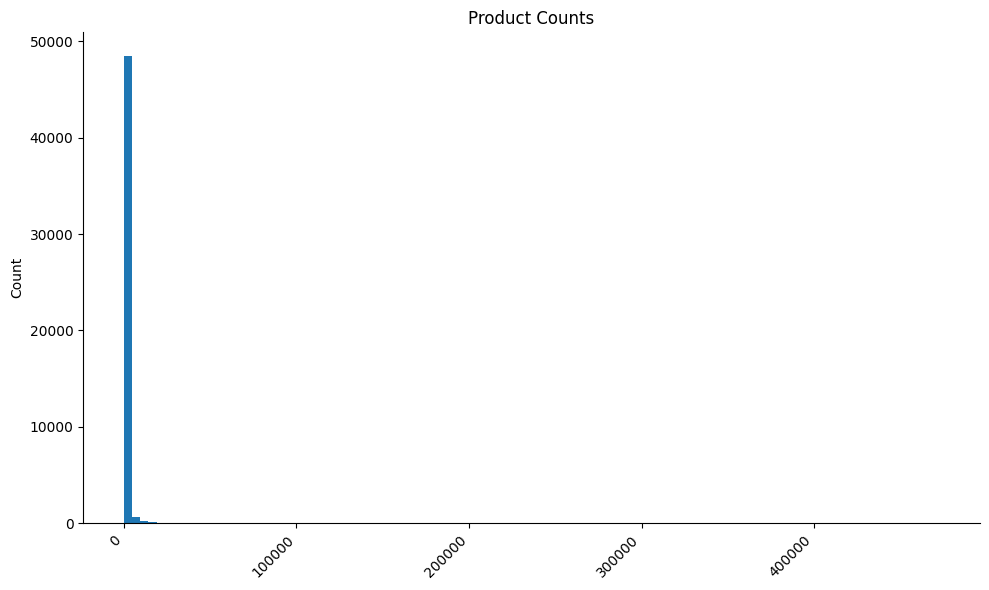

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Product count for each product
product_counts = fact_df.groupBy("product_id").count().orderBy("count", ascending=False)

# Convert to pandas for plotting
product_counts_pd = product_counts.toPandas()
# column count as int
product_counts_pd['count'] = product_counts_pd['count'].astype(int)
product_counts_pd = product_counts_pd.sort_values(by='count', ascending=False)
# Plotting
plt.figure(figsize=(10, 6))
# order by count

product_counts_pd['count'].plot(kind='hist', bins=100, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.ylabel('Count')
plt.title('Product Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

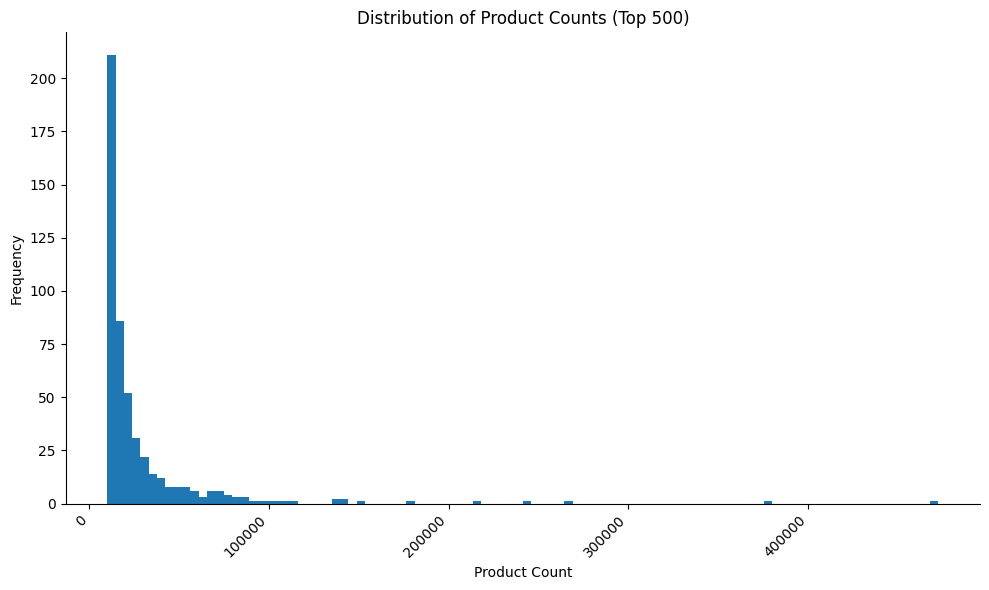

The top 500 products represent 42.89% of the total product count.


In [ ]:
plt.figure(figsize=(10, 6))
# id as str
product_counts_pd['product_id'] = product_counts_pd['product_id'].astype(str)
product_counts_pd.head(500)['count'].plot(kind='hist', bins=100, title='Count of Top 500 Products')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.ylabel('Frequency')
plt.xlabel('Product Count')
plt.title('Distribution of Product Counts (Top 500)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the total count of all products
total_count = product_counts_pd['count'].sum()

# Calculate the total count of the top 500 products
top_500_count = product_counts_pd.head(500)['count'].sum()

# Calculate the percentage represented by the top 500 products
percentage_top_500 = (top_500_count / total_count) * 100

print(f"The top 500 products represent {percentage_top_500:.2f}% of the total product count.")

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, struct, lit, log, count, collect_list, size, explode
from pyspark.sql import functions as F
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql.functions import count, desc

# Clusterização por produto

## TF-IDF com 500 produtos mais frequentes

In [ ]:
sql_query_top_products = """
SELECT product_id, COUNT(*) as product_count
FROM fact_orders
GROUP BY product_id
ORDER BY product_count DESC
LIMIT 500
"""

top_products_df = spark.sql(sql_query_top_products)

top_products_df.createOrReplaceTempView("top_500_products")

In [ ]:
sql_query = """
SELECT user_id,
  collect_list(product_name) as products
FROM fact_orders fo
  JOIN dim_products da
    ON da.product_id = fo.product_id
WHERE fo.product_id IN (SELECT product_id FROM top_500_products)
GROUP BY user_id
"""

df_products = spark.sql(sql_query)

In [ ]:
exploded_df = df_products.withColumn("product", explode(col("products")))

tf_df = exploded_df.groupBy("user_id", "product").agg(count("product").alias("tf"))

df_df = exploded_df.groupBy("product").agg(count("user_id").alias("df"))

total_docs = df_products.count()

idf_df = df_df.withColumn("idf", log(lit(total_docs) / (col("df") + 1)))

tfidf_df = tf_df.join(idf_df, "product").withColumn("tfidf", col("tf") * col("idf"))

from pyspark.sql.functions import regexp_replace

# Replace problematic characters in the `product` column
sanitized_df = tfidf_df.withColumn(
    "product",
    regexp_replace(col("product"), "[^a-zA-Z0-9_]", "_")
)

pivot_df = (
    sanitized_df.groupBy("user_id")
    .pivot("product")
    .agg({"tfidf": "max"})  # Aggregate by max
    .fillna(0)
)

feature_columns = [col for col in pivot_df.columns if col != "user_id"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_df = assembler.transform(pivot_df)

In [ ]:
num_components = 3

pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")

pca_model = pca.fit(final_df)

pca_result = pca_model.transform(final_df)

In [ ]:
k_values = [2, 3, 4, 5]

best_score = -1
best_model = None
clusters=None
silhouette_scores = []
for k in k_values:
  kmeans = KMeans(featuresCol="pca_features", k=k, seed=42)
  kmeans_model = kmeans.fit(pca_result)
  kmeans_clusters = kmeans_model.transform(pca_result)

  # Avaliação dos clusters
  evaluator = ClusteringEvaluator(featuresCol="pca_features")
  silhouette_score = evaluator.evaluate(kmeans_clusters)
  print(f"Silhouette Score: {silhouette_score}")

  # printar quantidade em cada cluster
  cluster_counts = kmeans_clusters.groupBy("prediction").count()
  cluster_counts.show()

  silhouette_scores.append(silhouette_score)

  if silhouette_score > best_score:
        best_score = silhouette_score
        best_model = kmeans_model
        clusters = kmeans_clusters

Silhouette Score: 0.8467251154561765
+----------+------+
|prediction| count|
+----------+------+
|         1|185415|
|         0| 17406|
+----------+------+

Silhouette Score: 0.6962013277461057
+----------+------+
|prediction| count|
+----------+------+
|         1|167536|
|         2| 28968|
|         0|  6317|
+----------+------+

Silhouette Score: 0.7549556067098949
+----------+------+
|prediction| count|
+----------+------+
|         1|166919|
|         3|  6186|
|         2|  1289|
|         0| 28427|
+----------+------+

Silhouette Score: 0.7620450167350721
+----------+------+
|prediction| count|
+----------+------+
|         1|165115|
|         3|  6163|
|         4|   344|
|         2|  2905|
|         0| 28294|
+----------+------+



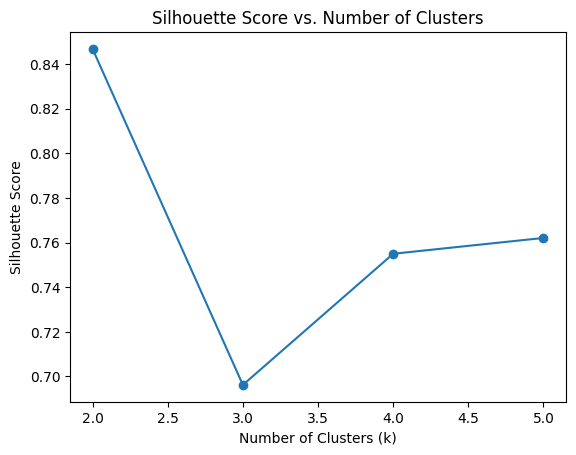

In [ ]:
# plot silhuetas para cada valor de cluster
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

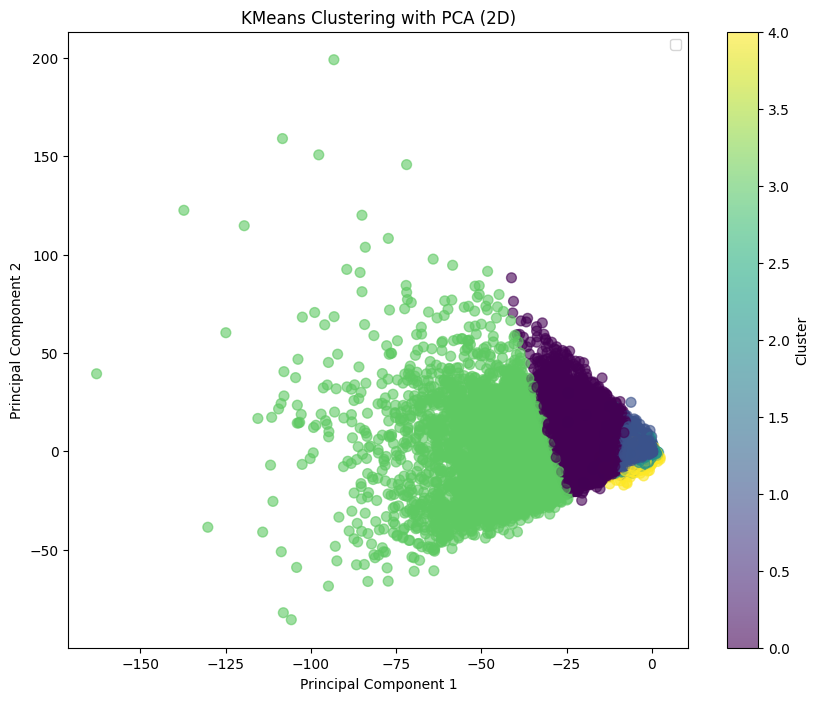

In [ ]:
# Reduzir as dimensões para 2D para visualização
pca_result_with_predictions = kmeans_clusters.withColumn("cluster", col("prediction"))

pca_2d = PCA(k=2, inputCol="pca_features", outputCol="pca_features_reduced")
pca_2d_model = pca_2d.fit(pca_result_with_predictions)
reduced_features = pca_2d_model.transform(pca_result_with_predictions)

reduced_data_pd = reduced_features.select("pca_features_reduced", "cluster").toPandas()
reduced_data_pd["x"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[0])
reduced_data_pd["y"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[1])


plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data_pd["x"],
    reduced_data_pd["y"],
    c=reduced_data_pd["cluster"],
    cmap="viridis",
    s=50,
    alpha=0.6
)

plt.colorbar(scatter, label="Cluster")
plt.title("KMeans Clustering with PCA (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Análise por corredor

## TF-IDF

In [ ]:
sql_query = """
SELECT user_id,
  collect_list(aisle) as aisles
FROM fact_orders fo
  JOIN dim_aisles da
    ON da.aisle_id = fo.aisle_id
GROUP BY user_id
"""

df_aisles = spark.sql(sql_query)

In [ ]:
exploded_df = df_aisles.withColumn("aisle", explode(col("aisles")))

tf_df = exploded_df.groupBy("user_id", "aisle").agg(count("aisle").alias("tf"))

df_df = exploded_df.groupBy("aisle").agg(count("user_id").alias("df"))

total_docs = df_aisles.count()

idf_df = df_df.withColumn("idf", log(lit(total_docs) / (col("df") + 1)))

tfidf_df = tf_df.join(idf_df, "aisle").withColumn("tfidf", col("tf") * col("idf"))

pivot_df = (
    tfidf_df.groupBy("user_id")
    .pivot("aisle")
    .agg({"tfidf": "max"})  # Aggregate by max
    .fillna(0)
)

feature_columns = [col for col in pivot_df.columns if col != "user_id"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_df = assembler.transform(pivot_df)

In [ ]:
num_components = 3

pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")

pca_model = pca.fit(final_df)

pca_result = pca_model.transform(final_df)

In [ ]:
k_values = [2, 3, 4, 5]

best_score = -1
best_model = None
clusters=None
silhouette_scores = []
for k in k_values:
  kmeans = KMeans(featuresCol="pca_features", k=k, seed=42)
  kmeans_model = kmeans.fit(pca_result)
  kmeans_clusters = kmeans_model.transform(pca_result)

  # Avaliação dos clusters
  evaluator = ClusteringEvaluator(featuresCol="pca_features")
  silhouette_score = evaluator.evaluate(kmeans_clusters)
  print(f"Silhouette Score: {silhouette_score}")

  # printar quantidade em cada cluster
  cluster_counts = kmeans_clusters.groupBy("prediction").count()
  cluster_counts.show()

  silhouette_scores.append(silhouette_score)

  if silhouette_score > best_score:
        best_score = silhouette_score
        best_model = kmeans_model
        clusters_aisles = kmeans_clusters

Silhouette Score: 0.8962951412887449
+----------+------+
|prediction| count|
+----------+------+
|         1| 14622|
|         0|191587|
+----------+------+

Silhouette Score: 0.8439669405641119
+----------+------+
|prediction| count|
+----------+------+
|         1|  3633|
|         2| 21499|
|         0|181077|
+----------+------+

Silhouette Score: 0.837827382821241
+----------+------+
|prediction| count|
+----------+------+
|         1|  2444|
|         3|  2904|
|         2| 20843|
|         0|180018|
+----------+------+

Silhouette Score: 0.7170898024580548
+----------+------+
|prediction| count|
+----------+------+
|         1|151440|
|         3|  1368|
|         4|  2598|
|         2|  8279|
|         0| 42524|
+----------+------+



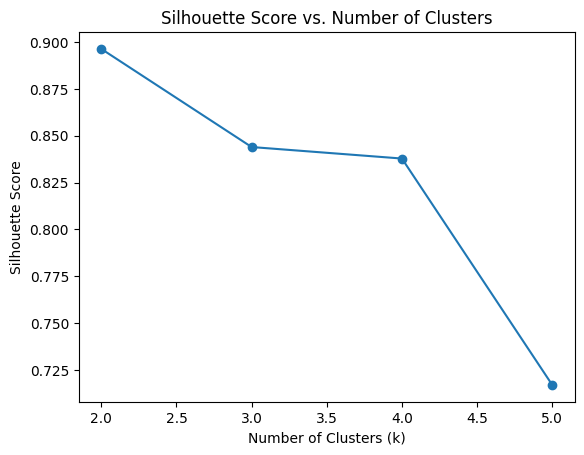

In [ ]:
# plot silhuetas para cada valor de cluster
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

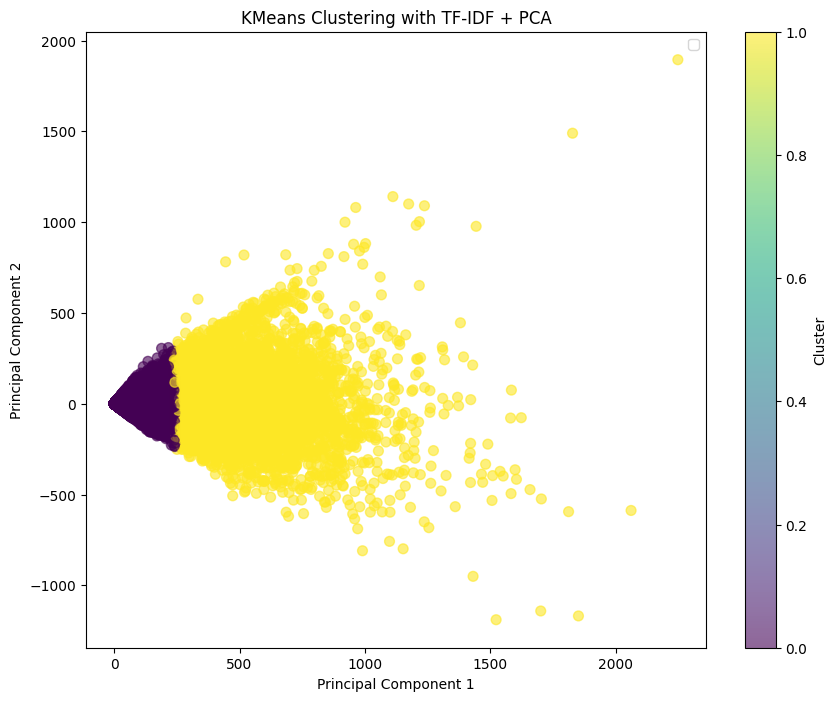

In [ ]:
# Reduzir as dimensões para 2D para visualização
pca_result_with_predictions = clusters_aisles.withColumn("cluster", col("prediction"))

pca_2d = PCA(k=2, inputCol="pca_features", outputCol="pca_features_reduced")
pca_2d_model = pca_2d.fit(pca_result_with_predictions)
reduced_features = pca_2d_model.transform(pca_result_with_predictions)

reduced_data_pd = reduced_features.select("pca_features_reduced", "cluster").toPandas()
reduced_data_pd["x"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[0])
reduced_data_pd["y"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[1])


plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data_pd["x"],
    reduced_data_pd["y"],
    c=reduced_data_pd["cluster"],
    cmap="viridis",
    s=50,
    alpha=0.6
)

plt.colorbar(scatter, label="Cluster")
plt.title("KMeans Clustering with TF-IDF + PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [ ]:
k_values = [2, 3, 4, 5]

best_score = -1
best_model = None
clusters=None
silhouette_scores = []
for k in k_values:
  kmeans = KMeans(distanceMeasure='cosine',featuresCol="features", k=k, seed=42)
  kmeans_model = kmeans.fit(final_df)
  kmeans_clusters = kmeans_model.transform(final_df)

  # Avaliação dos clusters
  evaluator = ClusteringEvaluator(featuresCol="features")
  silhouette_score = evaluator.evaluate(kmeans_clusters)
  print(f"Silhouette Score: {silhouette_score}")

  # printar quantidade em cada cluster
  cluster_counts = kmeans_clusters.groupBy("prediction").count()
  cluster_counts.show()

  silhouette_scores.append(silhouette_score)

  if silhouette_score > best_score:
        best_score = silhouette_score
        best_model = kmeans_model
        clusters = kmeans_clusters

Silhouette Score: -0.1778001778583769
+----------+------+
|prediction| count|
+----------+------+
|         1| 50438|
|         0|155771|
+----------+------+

Silhouette Score: -0.036949234750314905
+----------+-----+
|prediction|count|
+----------+-----+
|         1|80247|
|         2|51261|
|         0|74701|
+----------+-----+

Silhouette Score: -0.40630104421620233
+----------+------+
|prediction| count|
+----------+------+
|         1| 26691|
|         3| 56844|
|         2| 22322|
|         0|100352|
+----------+------+

Silhouette Score: -0.38800924792496894
+----------+-----+
|prediction|count|
+----------+-----+
|         1|20973|
|         3|52832|
|         4|45857|
|         2|25007|
|         0|61540|
+----------+-----+



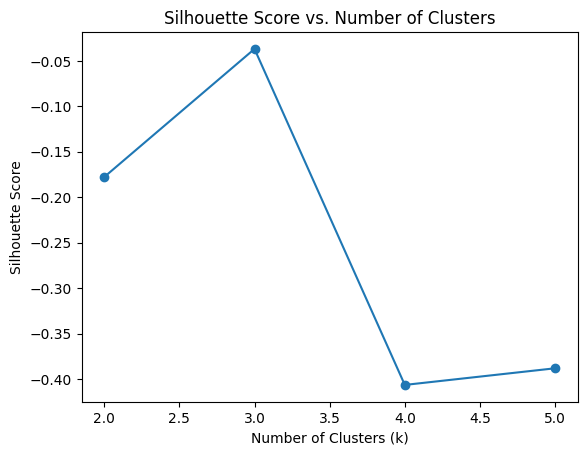

In [ ]:
# plot silhuetas para cada valor de cluster
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

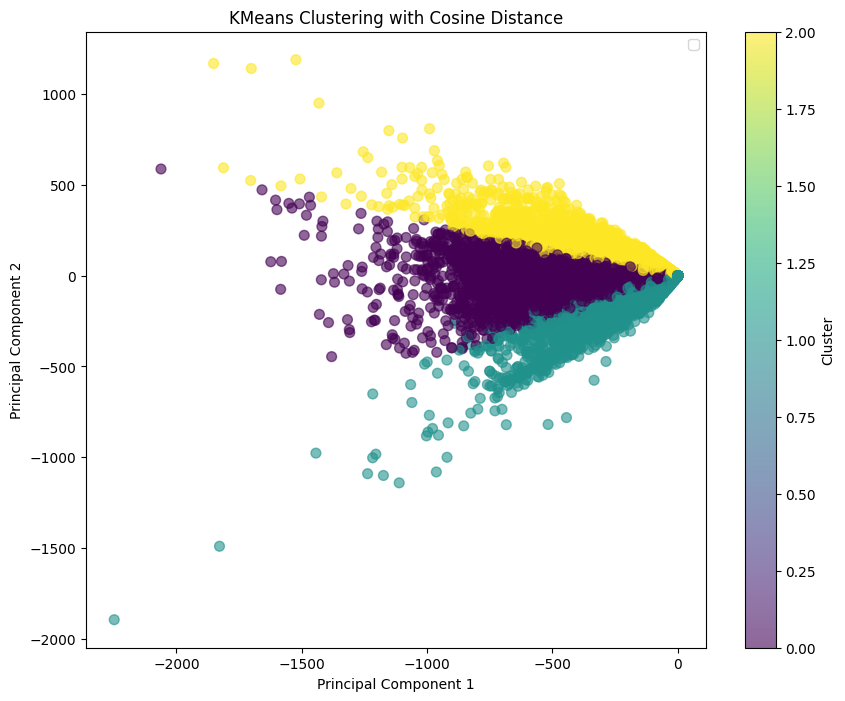

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reduzir as dimensões para 2D para visualização
pca_result_with_predictions = clusters.withColumn("cluster", col("prediction"))

pca_2d = PCA(k=2, inputCol="features", outputCol="pca_features_reduced")
pca_2d_model = pca_2d.fit(pca_result_with_predictions)
reduced_features = pca_2d_model.transform(pca_result_with_predictions)

reduced_data_pd = reduced_features.select("pca_features_reduced", "cluster").toPandas()
reduced_data_pd["x"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[0])
reduced_data_pd["y"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[1])


plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data_pd["x"],
    reduced_data_pd["y"],
    c=reduced_data_pd["cluster"],
    cmap="viridis",
    s=50,
    alpha=0.6
)

plt.colorbar(scatter, label="Cluster")
plt.title("KMeans Clustering with Cosine Distance")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# RNN para geração de embeddings considerando ordem do pedido e do carrinho

In [ ]:
sql_query = """
SELECT user_id,
  order_id,
  add_to_cart_order,
  fo.product_id
FROM fact_orders fo
  JOIN dim_products da
    ON da.product_id = fo.product_id
WHERE fo.product_id IN (SELECT product_id FROM top_500_products)
GROUP BY user_id, order_id, add_to_cart_order, fo.product_id
"""

df_products = spark.sql(sql_query)

sql_query = """
select * from top_500_products

"""

products = spark.sql(sql_query)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, row_number, udf
from pyspark.sql.window import Window
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
from pyspark.sql.types import IntegerType

In [ ]:
product_ids = products.select("product_id").distinct().rdd.map(lambda row: row["product_id"]).collect()

label_encoder = LabelEncoder()
label_encoder.fit(product_ids)

product_id_to_encoded = {product: idx for idx, product in enumerate(label_encoder.classes_)}
broadcast_mapping = spark.sparkContext.broadcast(product_id_to_encoded)

def encode_product_id(product_id):
    return broadcast_mapping.value.get(product_id, -1)  # Return -1 if the product ID is unknown

encode_udf = udf(encode_product_id, IntegerType())

df_products = df_products.withColumn("encoded_product_id", encode_udf(col("product_id")))

# Create ordered sequences per user
window_spec = Window.partitionBy("user_id").orderBy("order_id", "add_to_cart_order")
df_products = df_products.withColumn("sequence_index", row_number().over(window_spec))

# Collect sequences grouped by `user_id`
user_sequences_df = df_products.groupBy("user_id").agg(
    collect_list("encoded_product_id").alias("product_sequence")
)

user_sequences = user_sequences_df.select("product_sequence").rdd.flatMap(lambda x: x).collect()
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

class UserSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        input_seq = torch.tensor(sequence[:-1], dtype=torch.long)
        target_seq = torch.tensor(sequence[1:], dtype=torch.long)
        return input_seq, target_seq

user_dataset = UserSequenceDataset(user_sequences)

def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)

    input_seqs_padded = pad_sequence(input_seqs, batch_first=True, padding_value=0)
    target_seqs_padded = pad_sequence(target_seqs, batch_first=True, padding_value=0)

    return input_seqs_padded, target_seqs_padded

data_loader = DataLoader(user_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

class ProductEmbeddingRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(ProductEmbeddingRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        logits = self.fc(output)
        return logits, hidden

vocab_size = len(label_encoder.classes_)
embed_dim = 32
hidden_dim = 64
model = ProductEmbeddingRNN(vocab_size, embed_dim, hidden_dim)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding in the loss calculation
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for input_seq, target_seq in data_loader:
        optimizer.zero_grad()
        logits, _ = model(input_seq)
        loss = criterion(logits.view(-1, vocab_size), target_seq.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}")

product_embeddings = model.embedding.weight.detach().numpy()
product_id_to_embedding = {label_encoder.inverse_transform([i])[0]: product_embeddings[i] for i in range(vocab_size)}

embedding_rdd = spark.sparkContext.parallelize(
    [(product_id, embedding.tolist()) for product_id, embedding in product_id_to_embedding.items()]
)
embeddings_df = embedding_rdd.toDF(["product_id", "embedding"])

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Convert the 'embedding' list to a vector
assembler = VectorAssembler(inputCols=["embedding"], outputCol="features")
embeddings_df = assembler.transform(embeddings_df)

k_values = [2,3,4,5]
best_score = -1
best_model = None
clusters = None
silhouette_score = []

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    kmeans_model = kmeans.fit(embeddings_df)
    kmeans_clusters = kmeans_model.transform(embeddings_df)

    # Evaluate the clusters
    evaluator = ClusteringEvaluator(featuresCol="features")
    silhouette_score = evaluator.evaluate(kmeans_clusters)
    print(f"Silhouette Score: {silhouette_score}")
    silhouette_score.append(silhouette_score)

    if silhouette_score > best_score:
        best_score = silhouette_score
        best_model = kmeans_model
        kmeans_clusters_embedding = kmeans_clusters

In [ ]:
# plot silhuetas para cada valor de cluster
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reduzir as dimensões para 2D para visualização
result_with_predictions = kmeans_clusters_embedding.withColumn("cluster", col("prediction"))

pca_2d = PCA(k=2, inputCol="features", outputCol="pca_features_reduced")
pca_2d_model = pca_2d.fit(result_with_predictions)
reduced_features = pca_2d_model.transform(result_with_predictions)

reduced_data_pd = reduced_features.select("pca_features_reduced", "cluster").toPandas()
reduced_data_pd["x"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[0])
reduced_data_pd["y"] = reduced_data_pd["pca_features_reduced"].apply(lambda v: v[1])


# Step 5: Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data_pd["x"],
    reduced_data_pd["y"],
    c=reduced_data_pd["cluster"],
    cmap="viridis",
    s=50,
    alpha=0.6
)

plt.colorbar(scatter, label="Cluster")
plt.title("KMeans Clustering with PCA (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Escolhendo KMeans para visualização dos clusters

Escolhendo N=3, pela curva do silhouette score

In [ ]:
k = 3

kmeans = KMeans(featuresCol="pca_features", k=k, seed=42)
kmeans_model = kmeans.fit(pca_result)
kmeans_clusters = kmeans_model.transform(pca_result)


In [ ]:
sql_query = """
SELECT user_id,
  aisle
FROM fact_orders fo
  JOIN dim_aisles da
    ON da.aisle_id = fo.aisle_id
GROUP BY user_id, aisle
"""

aisles = spark.sql(sql_query)

In [ ]:
from pyspark.sql.functions import col


# Merge the DataFrames based on 'user_id', keeping only the necessary columns
merged_df = aisles.join(kmeans_clusters, on="user_id", how="inner").select(
    aisles["user_id"], aisles["aisle"], kmeans_clusters["prediction"]
)

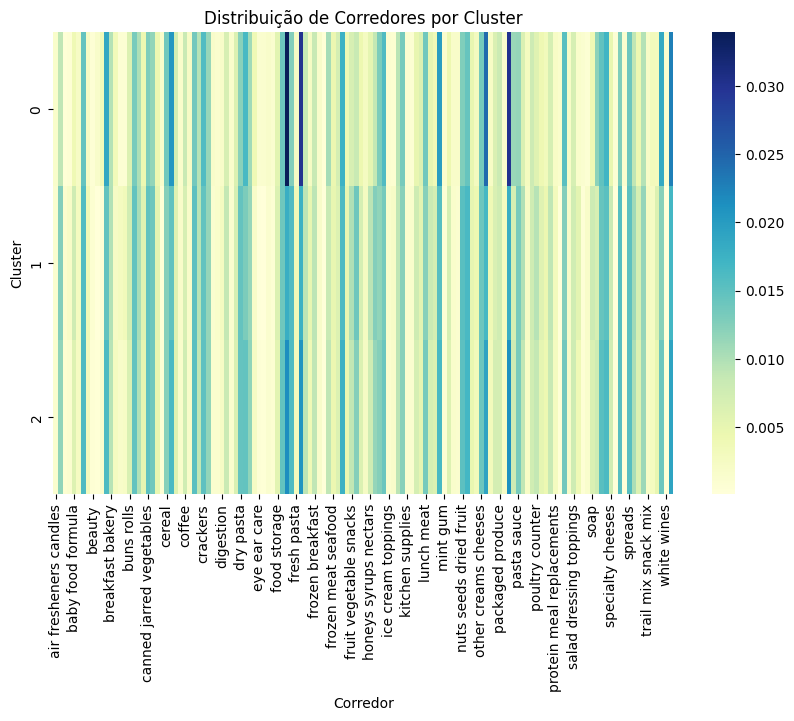

In [ ]:
aisles_distribution = merged_df.toPandas().groupby(['prediction', 'aisle']).size().unstack(fill_value=0)

# normalizar os valores
aisles_distribution = aisles_distribution.div(aisles_distribution.sum(axis=1), axis=0)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(aisles_distribution, cmap="YlGnBu", annot=False)
plt.title("Distribuição de Corredores por Cluster")
plt.xlabel("Corredor")
plt.ylabel("Cluster")
plt.show()


<ipython-input-18-e4fc10e5cd41>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")


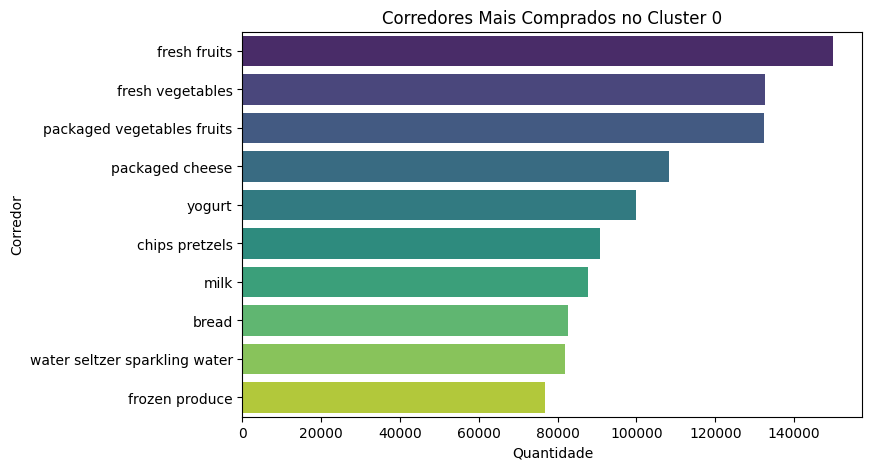

<ipython-input-18-e4fc10e5cd41>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")


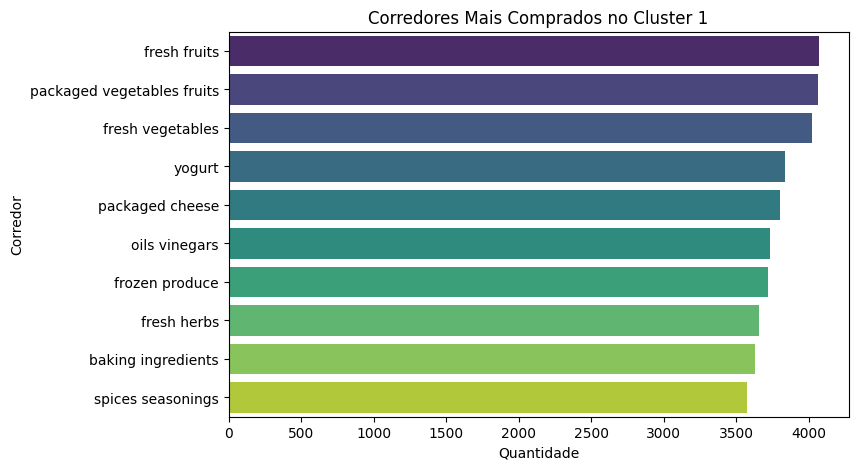

<ipython-input-18-e4fc10e5cd41>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")


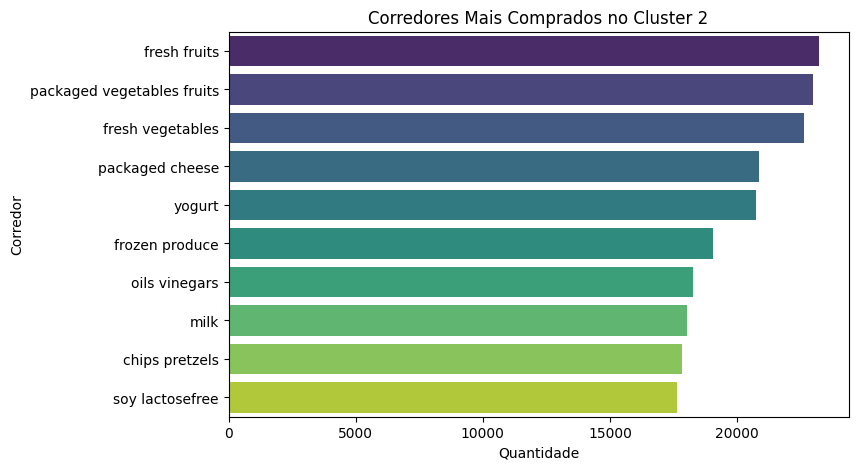

In [ ]:
aisle_counts = merged_df.toPandas().groupby(['prediction', 'aisle']).size().reset_index(name='count')

clusters = aisle_counts['prediction'].unique()
for cluster in clusters:
    # show the top 10

    cluster_aisles = aisle_counts[aisle_counts['prediction'] == cluster]

    cluster_aisles = cluster_aisles.sort_values(by='count', ascending=False)
    cluster_aisles = cluster_aisles.head(10)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")
    plt.title(f"Corredores Mais Comprados no Cluster {cluster}")
    plt.xlabel("Quantidade")
    plt.ylabel("Corredor")
    plt.show()

<ipython-input-19-533d584ba0d4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")


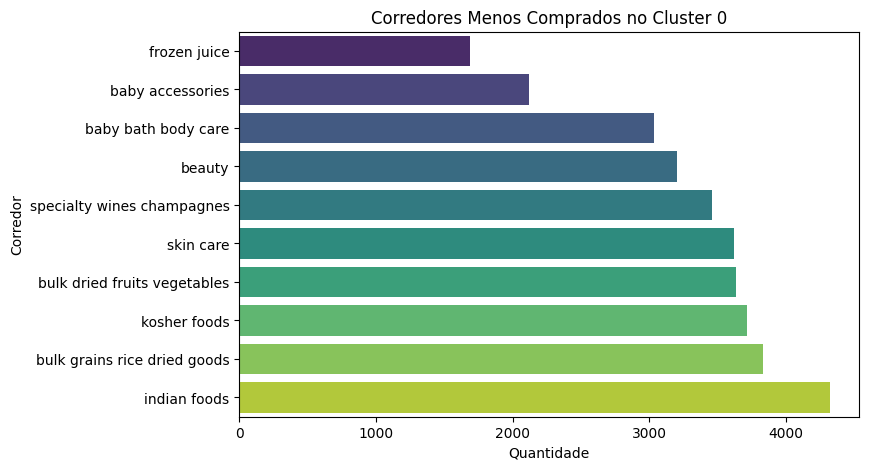

<ipython-input-19-533d584ba0d4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")


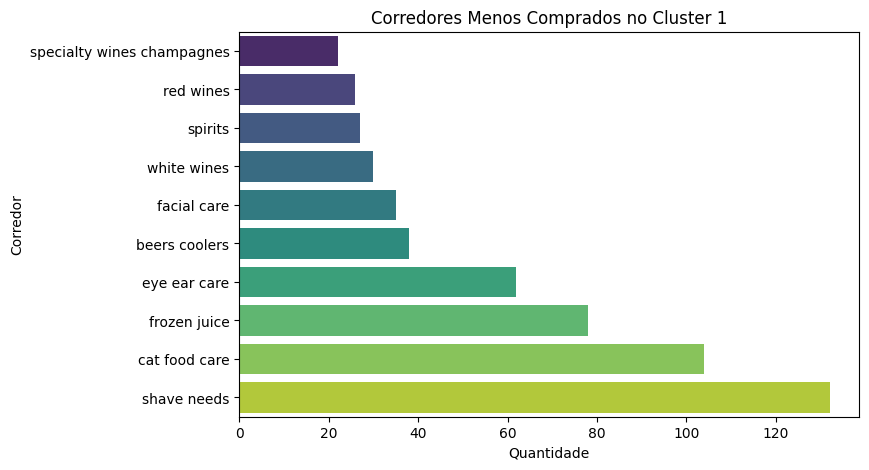

<ipython-input-19-533d584ba0d4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")


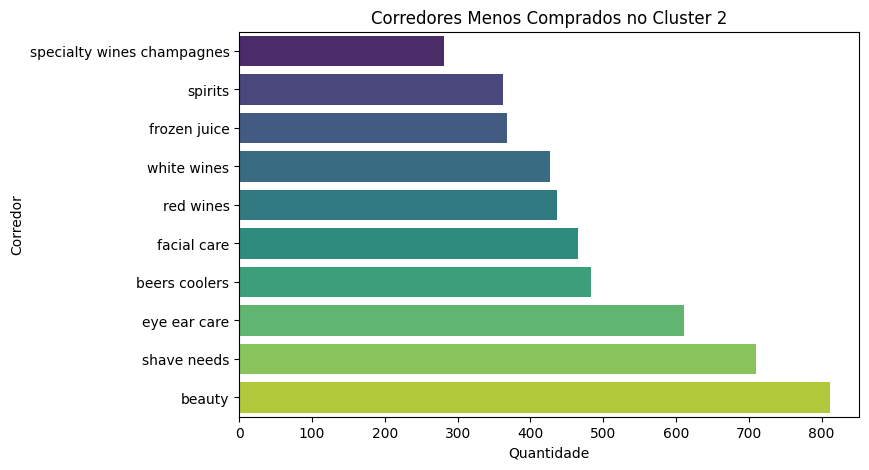

In [ ]:
aisle_counts = merged_df.toPandas().groupby(['prediction', 'aisle']).size().reset_index(name='count')

clusters = aisle_counts['prediction'].unique()
for cluster in clusters:
    # show the top 10

    cluster_aisles = aisle_counts[aisle_counts['prediction'] == cluster]

    cluster_aisles = cluster_aisles.sort_values(by='count', ascending=True)
    cluster_aisles = cluster_aisles.head(10)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=cluster_aisles, x='count', y='aisle', palette="viridis")
    plt.title(f"Corredores Menos Comprados no Cluster {cluster}")
    plt.xlabel("Quantidade")
    plt.ylabel("Corredor")
    plt.show()